In [17]:
import pandas as pd

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked,name_length,title,title_group,family_size,is_alone,ticket_group_size,cabin_score,name_word_count,Age_missing,Cabin_missing,log_Fare,log_fare_per_person,log_age_fare_ratio
0,1,1,female,35.0,1,0,S,47,Mrs,Mrs,2,0,2,9.173136,7,False,False,4.510860,3.828641,0.328504
1,0,2,male,19.0,0,0,S,31,Mr,Mr,1,1,1,9.064721,4,False,True,2.442347,2.442347,1.033015
2,0,2,male,34.0,0,0,S,28,Mr,Mr,1,1,1,2.131047,4,False,True,2.639057,2.639057,1.285198
3,1,3,female,4.0,0,2,S,35,Miss,Miss,3,0,1,1.148368,4,False,True,3.136581,3.136581,0.166879
4,1,2,female,21.0,0,0,S,17,Miss,Miss,1,1,1,3.922440,3,False,True,2.442347,2.442347,1.098612


In [18]:
cat_cols = ["Pclass","Sex","Embarked","title","title_group","is_alone","Age_missing","Cabin_missing"]

for col in cat_cols:
    train[col] = train[col].astype("category")
    test[col] = test[col].astype("category")
    
train.describe()

,Survived,Age,SibSp,Parch,name_length,family_size,ticket_group_size,cabin_score,name_word_count,log_Fare,log_fare_per_person,log_age_fare_ratio
count,668.000000,537.000000,668.000000,668.000000,668.000000,668.00000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000
mean,0.383234,29.931881,0.464072,0.375749,26.781437,1.83982,1.757485,4.943481,4.058383,2.934821,2.584898,0.770124
std,0.486539,14.455975,0.999353,0.832877,9.302036,1.51942,1.324836,2.935730,1.171067,0.973045,0.768793,0.623685
min,0.000000,0.420000,0.000000,0.000000,12.000000,1.00000,1.000000,0.046320,3.000000,0.000000,0.000000,0.000000
25%,0.000000,21.000000,0.000000,0.000000,20.000000,1.00000,1.000000,2.206988,3.000000,2.185579,2.169054,0.140867
50%,0.000000,29.000000,0.000000,0.000000,25.000000,1.00000,1.000000,4.986652,4.000000,2.698700,2.275315,0.809152
75%,1.000000,39.000000,1.000000,0.000000,30.000000,2.00000,2.000000,7.486077,4.000000,3.449988,3.141951,1.283346
max,1.000000,80.000000,8.000000,6.000000,82.000000,11.00000,7.000000,9.997177,14.000000,6.240917,5.406180,2.377652


There is a problem in titles as there's just too many categories that are not all present in both train and test, so we will drop it and use just title_group

In [19]:
train = train.drop(columns="title")
test = test.drop(columns="title")

In [20]:
response = train["Survived"]
predict = train.drop(columns="Survived")

response_test = test["Survived"]
predict_test = test.drop(columns="Survived")

predict = pd.get_dummies(predict, drop_first=True)
predict_test = pd.get_dummies(predict_test, drop_first=True)

Let's start by simply guessing at the hyper parameters to see how a basic fit is

In [21]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

rf.fit(predict, response)

,n_estimators,500
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [22]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

model_pred = rf.predict(predict_test)

print("Accuracy:", accuracy_score(response_test, model_pred))
print(confusion_matrix(response_test, model_pred))
print(classification_report(response_test, model_pred))

Accuracy: 0.8161434977578476
[[119  18]
 [ 23  63]]
              precision    recall  f1-score   support

           0       0.84      0.87      0.85       137
           1       0.78      0.73      0.75        86

    accuracy                           0.82       223
   macro avg       0.81      0.80      0.80       223
weighted avg       0.81      0.82      0.82       223



Just a guess at a random forest model is resulting in around 81.6% prediction accuracy which is pretty good. We'll now generate importance graph to see general variable importance.

<Axes: >

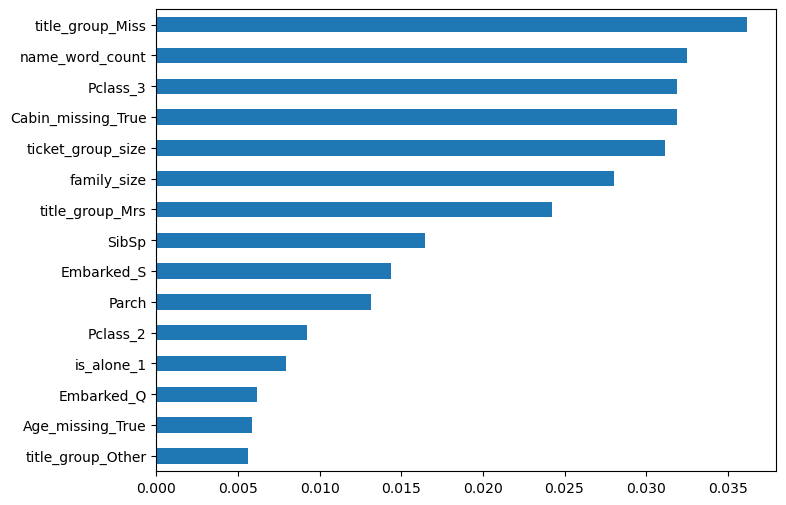

In [25]:
importance = pd.Series(
    rf.feature_importances_,
    index=predict.columns
).sort_values(ascending=True)

importance.head(15).plot(kind="barh", figsize=(8,6))

Could make some wild guesses right now, as women were let off first, longer names tend to denote wealthier class, pclass_3 is probably negative in that poor women survived less etc.

We'll now do some cross validation using rf's OOB estimates to save on processing power.

In [34]:
from sklearn.model_selection import ParameterSampler
from scipy.stats import randint
import numpy as np

param_ranges = {
    "n_estimators": randint(100, 1000),
    "max_depth": [None, 10, 15, 20, 25, 30],
    "min_samples_split": randint(2, 20),
    "min_samples_leaf": randint(1, 10),
    "max_features": ["sqrt", "log2"]
}

best_oob = -np.inf
best_params = None
best_model = None

for params in ParameterSampler(param_ranges, n_iter=50, random_state=42):
    rf = RandomForestClassifier(
        **params,
        oob_score=True,
        bootstrap=True,
        random_state=42,
        n_jobs=-1
    )
    
    rf.fit(predict, response)

    if rf.oob_score_ > best_score:
        best_oob = rf.oob_score_
        best_params = params
        best_model = rf

print("Best OOB score:", best_score)
print("Best params:", best_params)

Best OOB score: 0.8383233532934131
Best params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 724}


Seems like the best params are max depth of 10, features sqrt, min leafs 1, min splits 6, and n estimators 724, we can now generate a new rf model

In [35]:
rffinal = RandomForestClassifier(
    n_estimators=724,
    max_depth=10,
    max_features="sqrt",
    min_samples_leaf=1,
    min_samples_split=6,
    random_state=42,
    n_jobs=-1
)

rffinal.fit(predict, response)

model_pred = rffinal.predict(predict_test)

print("Accuracy:", accuracy_score(response_test, model_pred))
print(confusion_matrix(response_test, model_pred))
print(classification_report(response_test, model_pred))

Accuracy: 0.8071748878923767
[[117  20]
 [ 23  63]]
              precision    recall  f1-score   support

           0       0.84      0.85      0.84       137
           1       0.76      0.73      0.75        86

    accuracy                           0.81       223
   macro avg       0.80      0.79      0.80       223
weighted avg       0.81      0.81      0.81       223



We actually ended up with a worse model after CV compared to when we randomly guessed the parameters. This is possible as we might just be unlucky with the test set, but I would still suggest using the CV hyper parameters even though it performed worse as it should perform better given many tries.

<Axes: >

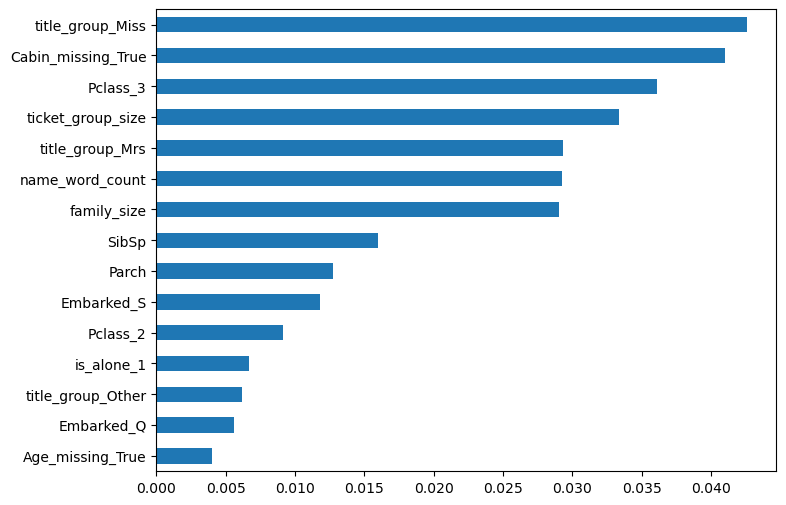

In [36]:
importance = pd.Series(
    rffinal.feature_importances_,
    index=predict.columns
).sort_values(ascending=True)

importance.head(15).plot(kind="barh", figsize=(8,6))

The importance graph is slightly different from before as well.